Import Libraries:

In [3]:
%matplotlib inline
# %matplotlib notebook
from sklearn.model_selection import train_test_split
import numpy as np
import qutip as qt
from qiskit.quantum_info import Statevector, DensityMatrix, entropy, partial_trace
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute
import tensorflow as tf
import matplotlib.pyplot as plt
# from vae import * 

2023-05-12 11:11:35.769539: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-12 11:11:35.898185: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-12 11:11:35.919145: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-12 11:11:35.919159: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [4]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a p-vector."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, beta_factor, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta_factor
        self.beta_scale = 1
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss")
        self.val_loss_tracker = tf.keras.metrics.Mean(
            name="val_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.val_loss_tracker
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.keras.losses.mean_squared_error(data, reconstruction), axis=-1))

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + self.beta_scale * self.beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
            }

    def test_step(self, data):
        _, _, z_test = self.encoder(data[0])
        test_reconstruction = self.decoder(z_test)
        val_loss = tf.reduce_mean(
            tf.reduce_sum(tf.keras.losses.mean_squared_error(data[0], test_reconstruction), axis=-1))
        self.val_loss_tracker.update_state(val_loss)
        return {"val_loss": self.val_loss_tracker.result()}

    def call(self, x):
        _, _, z = self.encoder(x)
        return self.decoder(z)


In [5]:
fig_size_dim    = 4
golden_ratio    = (1+np.sqrt(5))/2
fig_size        = (fig_size_dim, fig_size_dim/golden_ratio)

def plot_style():
    font_size       = 12
    dpi             = 200

    params = {'figure.figsize': fig_size,
              'figure.dpi': dpi,
              'savefig.dpi': dpi,
              'font.size': font_size,
              'font.family': "sans-serif",
              'font.sans-serif': ["Helvetica"],
              'figure.titlesize': font_size,
              'legend.fontsize': font_size,
              'axes.labelsize': font_size,
              'axes.titlesize': font_size,
              'xtick.labelsize': font_size,
              'ytick.labelsize': font_size,
              'text.usetex': True,
             }

    plt.rcParams.update(params)
plot_style()

In [9]:
# def circuit(theta):
#     q = QuantumRegister(3,'q')
#     circuit = QuantumCircuit(q)
#     circuit.ry(theta,q[0])
#     circuit.cnot(q[0],q[1])
#     circuit.cnot(q[0],q[2])
#     return circuit

def circuit_w(theta):
    q = QuantumRegister(3,'q')
    circuit = QuantumCircuit(q)
    circuit.ry(theta,q[0])
    circuit.ch(q[0],q[1])
    circuit.cnot(q[1],q[2])
    circuit.cnot(q[0],q[1])
    circuit.x(q[0])
    return circuit

def circuit_ghz(theta):
    q = QuantumRegister(3,'q')
    circuit = QuantumCircuit(q)
    circuit.h(q[0])
    circuit.cry(theta,q[0],q[1])
    circuit.cry(theta,q[0],q[2])
    return circuit

def get_dm(theta):
    state = Statevector.from_int(0, 2**3)
    state = state.evolve(circuit_w(theta))
    return DensityMatrix(state)


def get_entanglement(dm,tr):
    return entropy(partial_trace(dm,tr))

def get_u(n):
    z = np.random.randn(n,n)/np.sqrt(2.0)
    q,r = np.linalg.qr(z)
    d = np.diagonal(r)
    ph = d/np.absolute(d)
    q = np.multiply(q,ph,q)
    return q

def apply_u(dm):
    UaUb = qt.Qobj(
        np.kron(
            np.kron(get_u(2),get_u(2)),get_u(2) )
    ,dims = [[2, 2, 2], [2, 2, 2]])
    return  UaUb * dm * UaUb.dag() 

In [10]:
n_points = 21
max_angle = 2*np.arccos(1/np.sqrt(3)) 
scan_arr = np.linspace(0,max_angle,n_points)


n_samples = 100#750
# scan_arr = np.linspace(0,np.pi/2,n_points)
cnt = 0 
rho_arr_noisy = np.zeros((n_points,n_samples,8,8))
ee_arr = np.zeros((n_points*n_samples))
for i, theta in enumerate(scan_arr):   
        
    dm = get_dm(theta) 
    ee = get_entanglement(dm,[0,2])
    for inx, s in enumerate(range(n_samples)):
        ee_arr[cnt] = ee
        rho_arr_noisy[i,inx] = apply_u( qt.Qobj(dm.data,dims=[[2,2,2],[2,2,2]]))
        cnt += 1 
            
rho_arr_noisy = np.reshape(rho_arr_noisy,(n_points*n_samples,64))

alpha_arr = np.zeros(len(rho_arr_noisy))
cnt = 0
for theta in scan_arr:
        for _ in (range(n_samples)):
            alpha_arr[cnt] = theta
            cnt += 1
X_train, X_test, y_train, y_test, ee_train, ee_test = train_test_split(rho_arr_noisy, alpha_arr, ee_arr, random_state=42)
test_conc = np.array([qt.entropy_vn(qt.Qobj(dm.reshape(8,8),dims=[[2,2,2],[2,2,2]]).ptrace([0,1])) for dm in X_test])

/tmp/ipykernel_15921/2202913066.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  rho_arr_noisy[i,inx] = apply_u( qt.Qobj(dm.data,dims=[[2,2,2],[2,2,2]]))


Define Hyperparameters:

In [14]:
def vae_mlp(latent_dim, act_func, f_act):
    encoder_inputs = tf.keras.Input(shape=64)
    x = encoder_inputs
    x = tf.keras.layers.Dense(64, activation=act_func)(x)
    x = tf.keras.layers.Dense(8, activation=act_func)(x)
#     x = tf.keras.layers.Dense(4, activation=act_func)(x)

    z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    latent_inputs = tf.keras.Input(shape=(latent_dim,))
    x = latent_inputs
#     x = tf.keras.layers.Dense(4, activation=act_func)(x)
    x = tf.keras.layers.Dense(8, activation=act_func)(x)
#     x = tf.keras.layers.Dense(16, activation=act_func)(x)
    

    decoder_outputs = tf.keras.layers.Dense(64, activation=f_act)(x)
    decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")

    return encoder, decoder

In [155]:
batch_size = 64
beta = 0.1
learning_rate = 0.00001
lat_dim = 8
hidden_act = "tanh"
final_act = "linear"
n_epoch = 150

use_ramp = True

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='reconstruction_loss', factor=0.2,
                                                     patience=100, min_lr=0.0001)


In [156]:
encoder, decoder = vae_mlp(lat_dim, hidden_act, final_act)

vae_noisy = VAE(encoder, decoder, beta)

class KlRamp(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if use_ramp:
            vae_noisy.beta_pre = np.tanh(2 * epoch / (n_epoch // 2))
        else:
            1
            
vae_noisy.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [169]:
rloss_arr = []
kl_loss_arr = []
for i in range(n_epoch):
    hist_dict = vae_noisy.fit(X_train, epochs=1, batch_size=batch_size, verbose=1,callbacks=[reduce_lr])
    rloss_arr.append(hist_dict.history["reconstruction_loss"])
    kl_loss_arr.append(hist_dict.history["kl_loss"])

25/25 [==============================] - 0s 1ms/step - loss: 1.2199 - reconstruction_loss: 1.0678 - kl_loss: 1.3910 - lr: 1.0000e-05


25/25 [==============================] - 0s 1ms/step - loss: 1.1637 - reconstruction_loss: 1.0191 - kl_loss: 1.2737 - lr: 1.0000e-05


25/25 [==============================] - 0s 1ms/step - loss: 1.1361 - reconstruction_loss: 1.0096 - kl_loss: 1.1676 - lr: 1.0000e-05


In [170]:
z_mean, z_log_var, z = vae_noisy.encoder.predict(X_test)

17/17 [==============================] - 0s 1ms/step


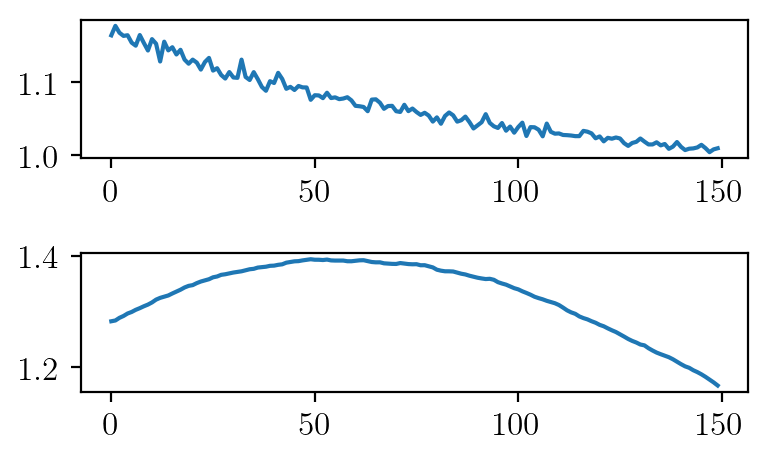

In [171]:
fig,axs = plt.subplots(2)
axs[0].plot(rloss_arr)
axs[1].plot(kl_loss_arr)
plt.tight_layout()

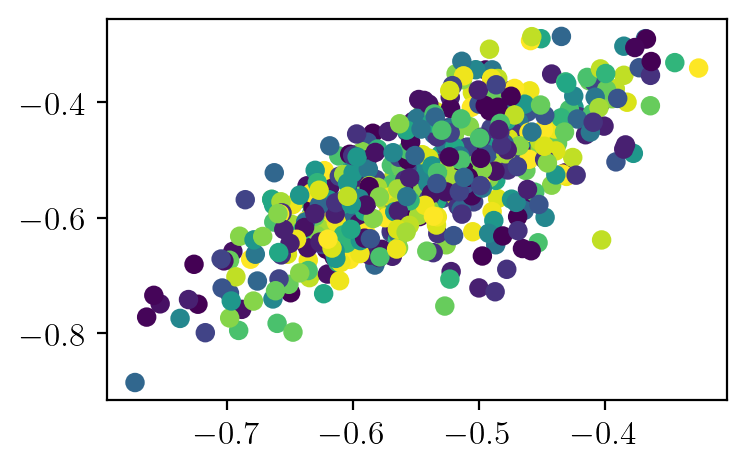

In [172]:
def gen_two_largest_z(z_mean_beta,z_log_var_beta):
    temp_arr = np.zeros(8)
    for i in range(8):
            temp_arr[i] = np.average(kl_loss(z_mean_beta[:,i], z_log_var_beta[:,i]))
    sort_inx = np.argsort(temp_arr)

    return z_mean_beta[:,sort_inx[-1]][::1], z_mean_beta[:,sort_inx[-2]][::1], z_log_var_beta[:,sort_inx[-1]][::1], z_log_var_beta[:,sort_inx[-2]][::1]

plt.scatter(,c=ee_test)
# plt.scatter(gen_two_largest_z(z_mean,z_log_var)[2],gen_two_largest_z(z_mean,z_log_var)[3],c=ee_test)

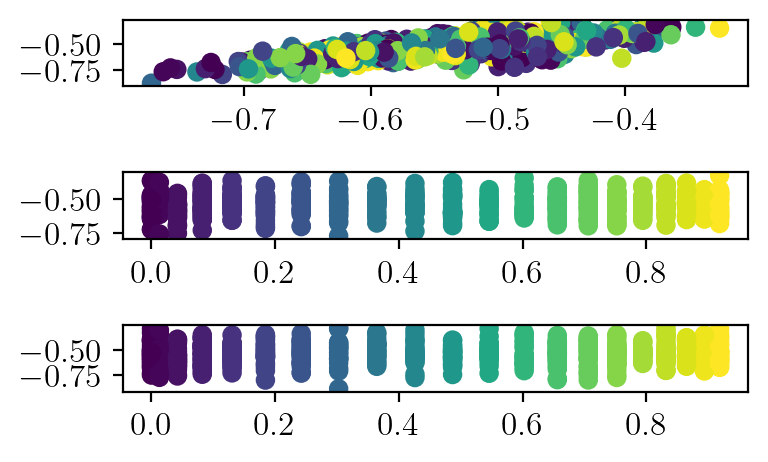

In [173]:
fig,ax = plt.subplots(3)
ax[0].scatter(gen_two_largest_z(z_mean,z_log_var)[0],gen_two_largest_z(z_mean,z_log_var)[1],c=ee_test)
ax[1].scatter(ee_test,gen_two_largest_z(z_mean,z_log_var)[0],c=ee_test)
ax[2].scatter(ee_test,gen_two_largest_z(z_mean,z_log_var)[1],c=ee_test)
plt.tight_layout()

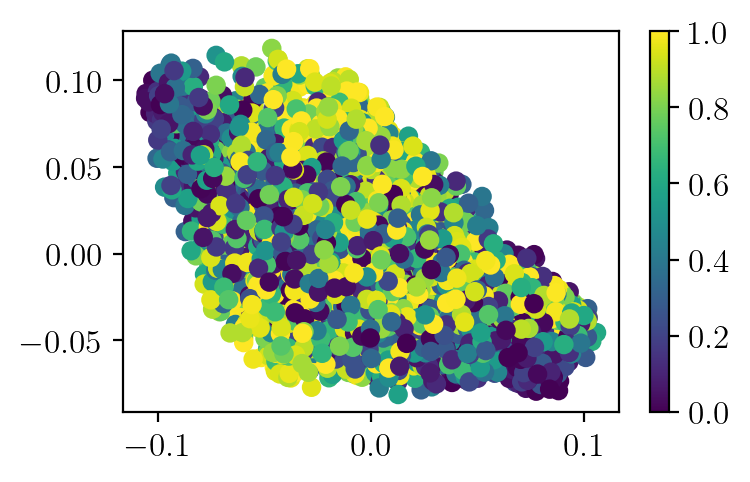

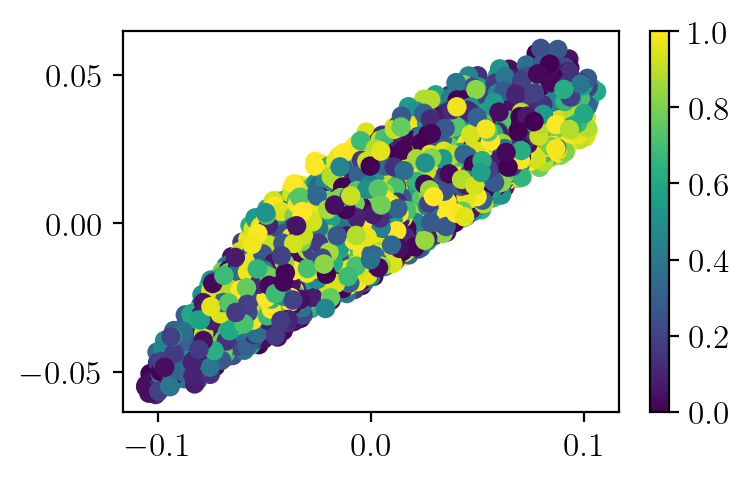

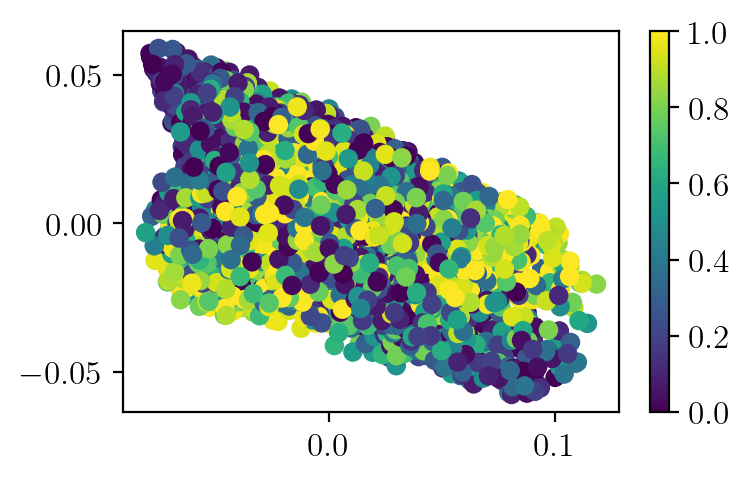

In [9]:
plot_scatter(z_mean[:,0],z_mean[:,1],ee_test,"","","",1)
plot_scatter(z_mean[:,0],z_mean[:,2],ee_test,"","","",1)
plot_scatter(z_mean[:,1],z_mean[:,2],ee_test,"","","",1)
# plot_scatter(y_test,z_mean[:,0],ee_test,"Angle $\\theta$","Latent Parameter $Z_0$","Concurrence",1)
# plot_scatter(y_test,z_mean[:,1],ee_test,"Angle $\\theta$","Latent Parameter $Z_0$","Concurrence",1)
# plot_scatter(y_test,z_mean[:,2],ee_test,"Angle $\\theta$","Latent Parameter $Z_0$","Concurrence",1)

Investigate Latent Space

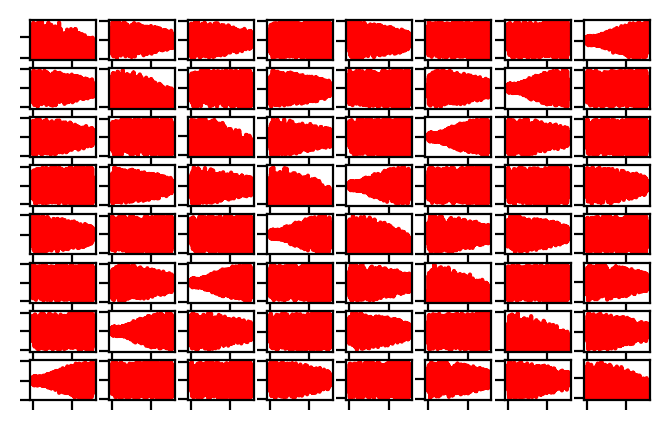

In [78]:
columns = 8
rows = 8
cnt = 0 
fig, ax_array = plt.subplots(rows, columns,squeeze=False)
for i,ax_row in enumerate(ax_array):
    for j,axes in enumerate(ax_row):
        axes.set_yticklabels([])
        axes.set_xticklabels([])
        axes.plot(rho_arr_noisy[:,cnt],'r-')
        cnt += 1
plt.show()

In [1]:
def vae_mlp_8x8(latent_dim, act_func, f_act):
    hid_dim = np.linspace(latent_dim,64,num = 5)[::-1]
    encoder_inputs = tf.keras.Input(shape=64)
    x = encoder_inputs
    x = tf.keras.layers.Dense(hid_dim[0], activation=act_func)(x)
   # x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(hid_dim[1], activation=act_func)(x)
   # x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(hid_dim[2], activation=act_func)(x)
   # x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(hid_dim[3], activation=act_func)(x)
   # x = tf.keras.layers.Dropout(0.2)(x)

    z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    latent_inputs = tf.keras.Input(shape=(latent_dim,))
    x = latent_inputs
    x = tf.keras.layers.Dense(hid_dim[3], activation=act_func)(x)
   # x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(hid_dim[2], activation=act_func)(x)
   # x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(hid_dim[1], activation=act_func)(x)
   # x = tf.keras.layers.Dropout(0.2)(x)

    decoder_outputs = tf.keras.layers.Dense(hid_dim[0], activation=f_act)(x)
    decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")

    return encoder, decoder


In [10]:
inx_dict = {"001":0.01,"01":0.1,"02":0.2,"03":0.3,
            "04":0.4,"05":0.5,"06":0.6,"07":0.7,
            "08":0.8,"09":0.9,"10":1.0,"11":1.1, "12":1.2}
beta_list = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2]

In [79]:
def kl_loss(mu, sig):
    return -0.5 * (1 + sig - mu ** 2 - np.exp(sig))

In [18]:
recon_loss_arr = np.zeros(len(inx_dict))
kl_loss_arr = np.zeros(len(inx_dict))
full_kl_loss_arr = np.zeros((len(inx_dict),8))
full_kl_loss_arr_2 = np.zeros((len(inx_dict),8))

cnt = 0
for inx,beta in inx_dict.items():

    encoder, decoder = vae_mlp_8x8(8, hidden_act, final_act)

    encoder.load_weights("/home/felix/Downloads/new_8x8/encoder_8_{}_8x8_scan_test.h5".format(inx))
    decoder.load_weights("/home/felix/Downloads/new_8x8/decoder_8_{}_8x8_scan_test.h5".format(inx))

    vae_beta = VAE(encoder, decoder, beta)
    vae_beta.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    history_dict = vae_beta.fit(X_test, epochs=1, batch_size=64, verbose=0) 

    recon_loss_arr[cnt] = history_dict.history["reconstruction_loss"][0]
    kl_loss_arr[cnt] = history_dict.history["kl_loss"][0]
    
    
    z_mean_beta, z_log_var_beta, z_beta = vae_beta.encoder.predict(X_test)
    
    for i in range(8):
        full_kl_loss_arr[cnt][i] = np.average(kl_loss(z_mean_beta[:,i].astype(np.float64), z_log_var_beta[:,i].astype(np.float64)).astype(np.float64))
        full_kl_loss_arr_2[cnt][i] = np.average(kl_loss(z_mean_beta[:,i], z_log_var_beta[:,i]))

    cnt += 1 
    
    
    
#     plot_scatter(z_mean[:,0],z_mean[:,1],concurrence_arr,"$Z_0$","$Z_1$","",1)

790/790 [==============================] - 0s 503us/step


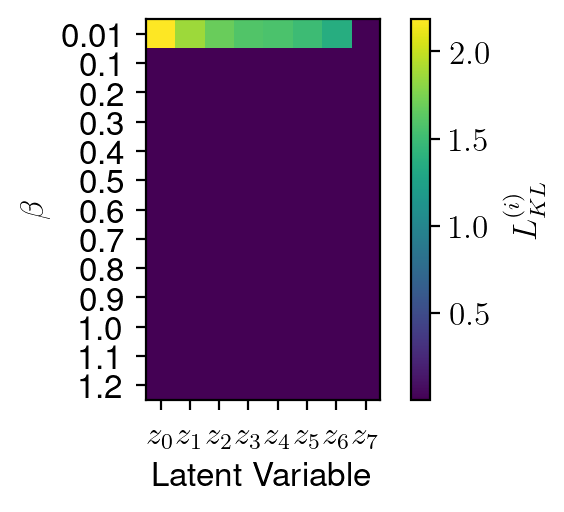

In [47]:
# row_sums = np.sort(full_kl_loss_arr,axis=-1).sum(axis=1)
new_matrix = np.sort(full_kl_loss_arr,axis=-1) #/ row_sums[:, np.newaxis]

# row_sums = np.sort(full_kl_loss_arr_2,axis=-1).sum(axis=1)
# new_matrix = np.sort(full_kl_loss_arr_2,axis=-1) / row_sums[:, np.newaxis]

fig, ax = plt.subplots()
im = ax.imshow(np.flip(new_matrix,axis=1))
cbar = fig.colorbar(im)
cbar.set_label("$L_{KL}^{(i)}$")
plt.xticks(range(8),["$z_{}$".format(i) for i in range(8)])
plt.yticks(range(len(inx_dict)),beta_list)

plt.xlabel("Latent Variable")
plt.ylabel("$\\beta$")

plt.show()

In [25]:
def gen_two_largest_z(beta):

    beta_inx = str(beta).replace(".","")
    
    learning_rate = 0.0001
    lat_dim = 8
    hidden_act = "tanh"
    final_act = "linear"

    encoder, decoder = vae_mlp_8x8(lat_dim, hidden_act, final_act)

    encoder.load_weights("/home/felix/Downloads/new_8x8/encoder_8_{}_8x8_scan_test.h5".format(beta_inx))
    decoder.load_weights("/home/felix/Downloads/new_8x8/decoder_8_{}_8x8_scan_test.h5".format(beta_inx))

    vae_beta = VAE(encoder, decoder, beta)
    vae_beta.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    history_dict = vae_beta.fit(X_test, epochs=1, batch_size=64, verbose=0) 
    z_mean_beta, z_log_var_beta, z_beta = vae_beta.encoder.predict(X_test)
        
    temp_arr = np.zeros(8)
    for i in range(8):
            temp_arr[i] = np.average(kl_loss(z_mean_beta[:,i], z_log_var_beta[:,i]))
    sort_inx = np.argsort(temp_arr)

#     for (i,j) in zip(np.arange(8)[sort_inx], temp_arr[sort_inx]):
#         print(i,j)

    return z_mean_beta[:,sort_inx[-1]][::1], z_mean_beta[:,sort_inx[-2]][::1]

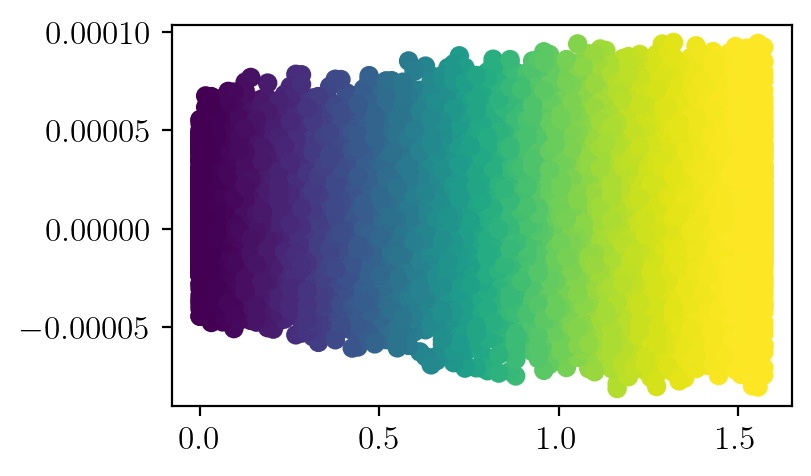

In [41]:
plt.scatter(y_test,z_06_1,c=test_conc)

790/790 [==============================] - 0s 468us/step


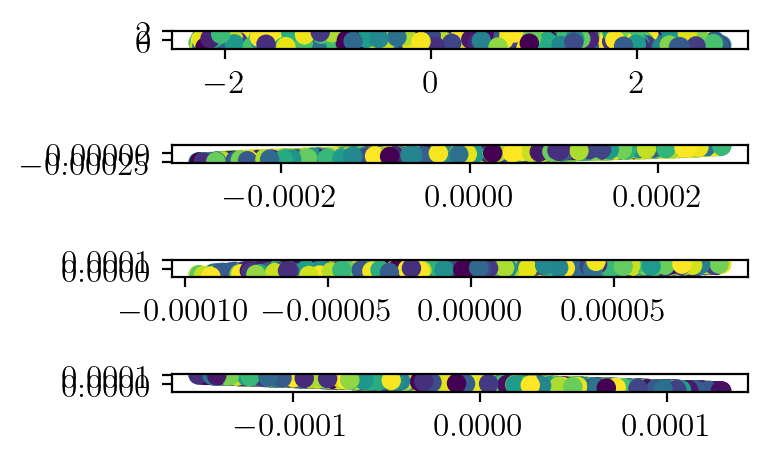

In [38]:
fig,axs = plt.subplots(4)

z_001_0, z_001_1 = gen_two_largest_z(0.01)
axs[0].scatter(z_001_0, z_001_1,c=test_conc)


z_02_0, z_02_1 = gen_two_largest_z(0.2)
axs[1].scatter(z_02_0, z_02_1,c=test_conc)

z_06_0, z_06_1 = gen_two_largest_z(0.6)
axs[2].scatter(z_06_0, z_06_1,c=test_conc)

z_1_0, z_1_1 = gen_two_largest_z(1.0)
axs[3].scatter(z_1_0, z_1_1,c=test_conc)

plt.tight_layout()